In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from lightgbm import early_stopping
import numpy as np


In [76]:
df_bogota = pd.read_csv('inmuebles_bogota 2.csv')


display(df_bogota.head())
display(df_bogota.info())
display(df_bogota.describe())

,Tipo,Descripcion,Habitaciones,Baños,Área,Barrio,UPZ,Valor
0,Apartamento,Apartamento en venta en Zona Noroccidental,3,2,70,Zona Noroccidental,CHAPINERO: Pardo Rubio + Chapinero,$ 360.000.000
1,Casa,Casa en venta en Castilla,4,3,170,Castilla,KENNEDY: Castilla + Bavaria,$ 670.000.000
2,Apartamento,Apartamento en venta en Chico Reservado,3,3,144,Chico Reservado,CHAPINERO: Chicó Lago + El Refugio,$ 1.120.000.000
3,Apartamento,Apartamento en venta en Usaquén,3,2,154,Usaquén,Usaquén,$ 890.000.000
4,Apartamento,Apartamento en venta en Bella Suiza,2,3,128,Bella Suiza,USAQUÉN: Country Club + Santa Bárbara,$ 970.000.000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9520 entries, 0 to 9519
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tipo          9520 non-null   object
 1   Descripcion   9520 non-null   object
 2   Habitaciones  9520 non-null   int64 
 3   Baños         9520 non-null   int64 
 4   Área          9520 non-null   int64 
 5   Barrio        9520 non-null   object
 6   UPZ           9478 non-null   object
 7   Valor         9520 non-null   object
dtypes: int64(3), object(5)
memory usage: 595.1+ KB


None

,Habitaciones,Baños,Área
count,9520.000000,9520.000000,9520.000000
mean,3.072479,2.447899,146.664706
std,2.049856,1.255314,1731.379622
min,1.000000,0.000000,2.000000
25%,2.000000,2.000000,57.000000
50%,3.000000,2.000000,80.000000
75%,3.000000,3.000000,135.000000
max,110.000000,9.000000,166243.000000


In [77]:
df_bogota.columns

Index(['Tipo', 'Descripcion', 'Habitaciones', 'Baños', 'Área', 'Barrio', 'UPZ',
       'Valor'],
      dtype='object')

In [78]:
# Seleccionar solo columnas necesarias
df_modelo = df_bogota[['Tipo', 'Habitaciones', 'Baños', 'Área', 'Barrio', 'Valor', 'UPZ']].copy()

# Limpiar columna Valor y convertir a float
df_modelo['Valor'] = df_modelo['Valor'].replace('[\$,\.]', '', regex=True).astype(float)



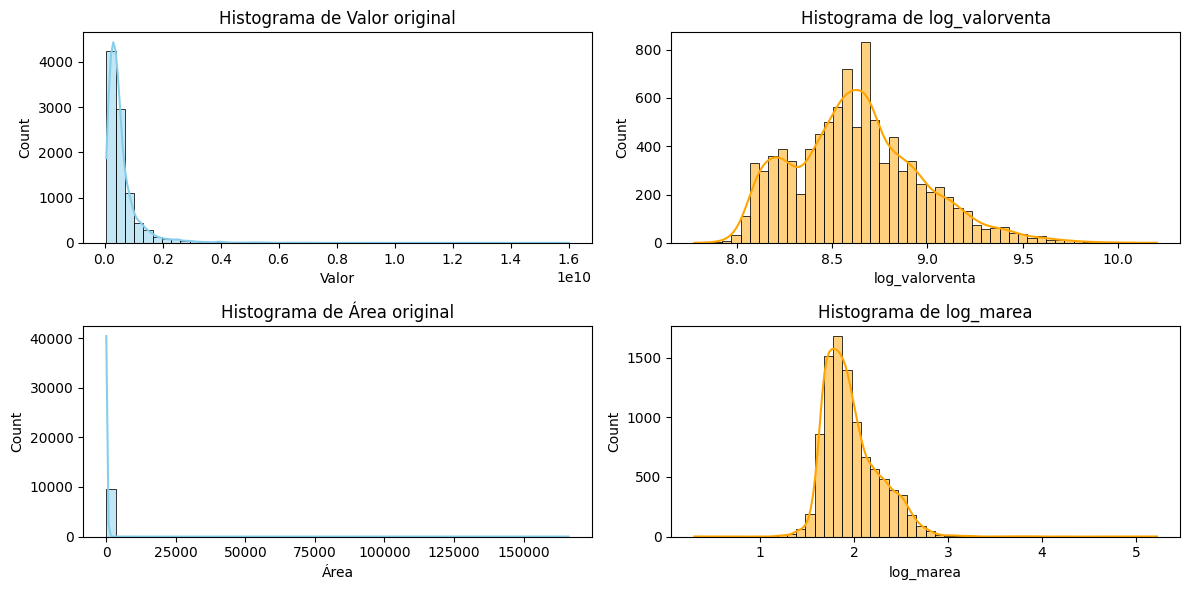

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Crear variables log
df_modelo['log_valorventa'] = np.log10(df_modelo['Valor'])
df_modelo['log_marea'] = np.log10(df_modelo['Área'])
df_filtrado = df_modelo.copy()

# Graficar histogramas antes y después del log
plt.figure(figsize=(12,6))

# Histograma de Valor original
plt.subplot(2,2,1)
sns.histplot(df_modelo['Valor'], bins=50, kde=True, color='skyblue')
plt.title("Histograma de Valor original")

# Histograma de log_valorventa
plt.subplot(2,2,2)
sns.histplot(df_modelo['log_valorventa'], bins=50, kde=True, color='orange')
plt.title("Histograma de log_valorventa")

# Histograma de Área original
plt.subplot(2,2,3)
sns.histplot(df_modelo['Área'], bins=50, kde=True, color='skyblue')
plt.title("Histograma de Área original")

# Histograma de log_marea
plt.subplot(2,2,4)
sns.histplot(df_modelo['log_marea'], bins=50, kde=True, color='orange')
plt.title("Histograma de log_marea")

plt.tight_layout()
plt.show()


Modelo de Regresion Lineal

In [82]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Seleccionar variables
X = df_filtrado[['log_marea']]  # variable de entrada
y = df_filtrado['log_valorventa']  # target

# Separar train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# SGD funciona mejor si los datos están escalados
model = make_pipeline(
    StandardScaler(),
    SGDRegressor(max_iter=1000, learning_rate='invscaling', eta0=0.01, random_state=42)
)

# Entrenar el modelo
model.fit(X_train, y_train)


,steps,"[('standardscaler', ...), ('sgdregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'squared_error'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15


In [83]:
# Predecir sobre datos de test
y_pred_log = model.predict(X_test)

# MAPE: Mean Absolute Percentage Error
mape = np.mean(np.abs((y_test - y_pred_log) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")


MAPE: 1.69%


In [84]:
sgd = model.named_steps['sgdregressor']
intercept = sgd.intercept_[0]
slope = sgd.coef_[0]

print(f"Intercepto: {intercept:.4f}")
print(f"Pendiente (coeficiente log_marea): {slope:.4f}")


Intercepto: 8.6313
Pendiente (coeficiente log_marea): 0.2759


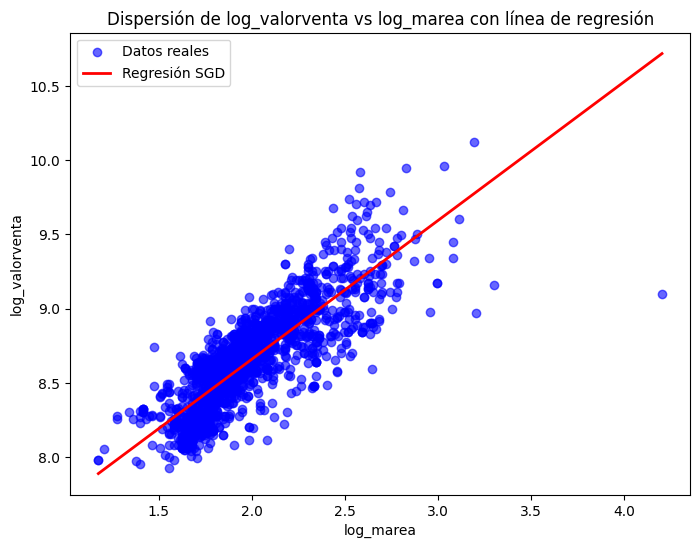

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Gráfico de dispersión
plt.scatter(X_test['log_marea'], y_test, color='blue', alpha=0.6, label='Datos reales')

X_test_sorted = X_test.sort_values(by='log_marea')
y_pred_sorted = model.predict(X_test_sorted)
plt.plot(X_test_sorted['log_marea'], y_pred_sorted, color='red', linewidth=2, label='Regresión SGD')

plt.xlabel("log_marea")
plt.ylabel("log_valorventa")
plt.title("Dispersión de log_valorventa vs log_marea con línea de regresión")
plt.legend()
plt.show()


Lightgbm

In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Seleccionar variables y usar log-transform donde corresponde
X = df_filtrado[['Tipo', 'Habitaciones', 'Baños', 'log_marea', 'Barrio']]  # 'Área' ya log-transformada
y = df_filtrado['log_valorventa']  # target log-transformado

X['Tipo'] = X['Tipo'].astype('category')
X['Barrio'] = X['Barrio'].astype('category')

# Separar train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_24708\3587804868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Tipo'] = X['Tipo'].astype('category')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24708\3587804868.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Barrio'] = X['Barrio'].astype('category')


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score

# Crear datasets para LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['Tipo', 'Barrio'])
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=['Tipo', 'Barrio'])

# Parámetros
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'verbose': -1
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[606]	valid_0's rmse: 0.109185


In [88]:
# Predecir sobre test
y_pred_log = model.predict(X_test)

# Métricas en escala logarítmica
rmse_log = np.sqrt(np.mean((y_test - y_pred_log)**2))
mae_log = mean_absolute_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)
mape_log = np.mean(np.abs((y_test - y_pred_log)/y_test)) * 100

print(f"RMSE (log10): {rmse_log:.4f}")
print(f"MAE (log10): {mae_log:.4f}")
print(f"R² (log10): {r2_log:.3f}")
print(f"MAPE (log10): {mape_log:.2f}%")


RMSE (log10): 0.1092
MAE (log10): 0.0780
R² (log10): 0.894
MAPE (log10): 0.89%


Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


X = df_filtrado[['log_marea', 'Habitaciones', 'Baños', 'Tipo', 'Barrio']]
y = df_filtrado['log_valorventa']

# Codificar variables categóricas
X = pd.get_dummies(X, columns=['Tipo', 'Barrio'], drop_first=True)

# Separar en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf = RandomForestRegressor(
    n_estimators=300,     # número de árboles
    max_depth=12,         # profundidad máxima (controla overfitting)
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


y_pred_log = rf.predict(X_test)


rmse_log = np.sqrt(np.mean((y_test - y_pred_log)**2))
mae_log = mean_absolute_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)
mape_log = np.mean(np.abs((y_test - y_pred_log)/y_test)) * 100

print(f"RMSE (log10): {rmse_log:.4f}")
print(f"MAE (log10): {mae_log:.4f}")
print(f"R² (log10): {r2_log:.3f}")
print(f"MAPE (log10): {mape_log:.2f}%")



RMSE (log10): 0.1072
MAE (log10): 0.0755
R² (log10): 0.898
MAPE (log10): 0.87%


Ridge

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Entrenar modelo
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)

# Predicciones
y_pred_log = ridge.predict(X_test)

# Metricas
mae_log = mean_absolute_error(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2_log = r2_score(y_test, y_pred_log)

print(f"MAE_log: {mae_log:.4f}")
print(f"RMSE_log: {rmse_log:.4f}")
print(f"R2_log: {r2_log:.4f}")




MAE_log: 0.0966
RMSE_log: 0.1339
R2_log: 0.8411


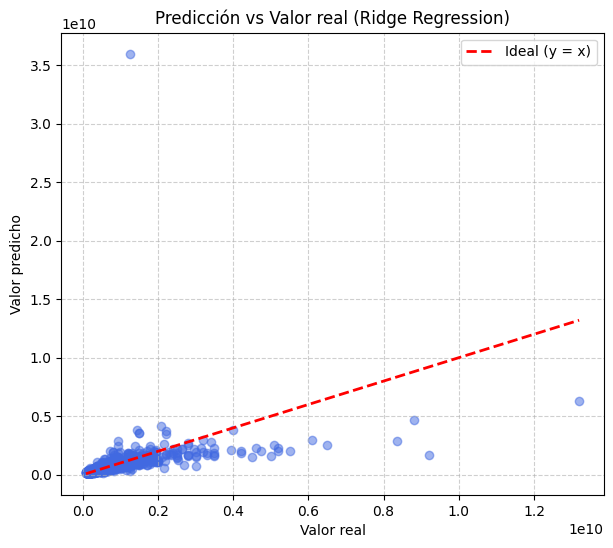

In [ ]:

y_test_real = np.power(10, y_test)
y_pred_real = np.power(10, y_pred_log)

plt.figure(figsize=(7,6))
plt.scatter(y_test_real, y_pred_real, alpha=0.5, color='royalblue')
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()],
         'r--', lw=2, label='Ideal (y = x)')
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Predicción vs Valor real (Ridge Regression)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()